# Non-parametric Statistics 
## Chapter 2: Kernel Density Estimation
### Bnadwidth Selection

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from scipy import stats
from scipy.integrate import quad

In [75]:
np.random.seed(99)

In [4]:
# this code should work for anyone who cloned the project via github
# as it ensures that you have the correct project structure
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))
plots_folder = os.path.join(project_root, "plots/chap2/bandwidths")

# Please check this is correct path, hopefully it works fine
plots_folder

'/Users/wuzm/UOEY4S2/nonparam-stats-proj/plots/chap2/bandwidths'

In [20]:
# Gaussian kernel function
def gaussian_kernel(x, sigma=1):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(- (x ** 2) / (2 * sigma ** 2))

def epanechnikov_kernel(x):
    return np.where(np.abs(x) <= 1, 0.75 * (1 - x**2), 0)

def uniform_kernel(u):
    return np.where(np.abs(u) <= 1, 0.5, 0)

def custom_kde(data, kernel_func, bandwidth, x_grid):
    kde_values = np.zeros_like(x_grid)
    for xi in data:
        kde_values += kernel_func((x_grid - xi) / bandwidth)
    return kde_values / (len(data) * bandwidth)

Illustration of variance-bias tradeoff in MSE

/var/folders/72/czpkdkzd62bbvhzjzt68qnlw0000gn/T/ipykernel_60620/152412732.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(h, squared_bias, 'k--', c='red', label='Bias squared')
/var/folders/72/czpkdkzd62bbvhzjzt68qnlw0000gn/T/ipykernel_60620/152412732.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-." (-> color='k'). The keyword argument will take precedence.
  plt.plot(h, variance, 'k-.', c='blue', label='Variance')


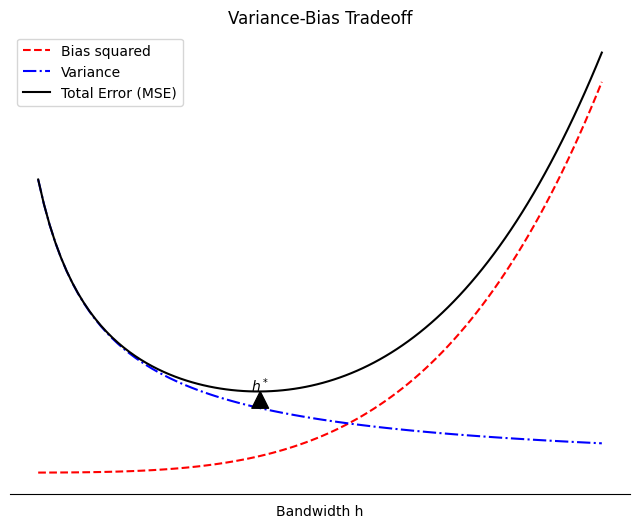

In [6]:
# Custom value for the variables
C_X = 300
M2 = 20
M = 40
sig_sqr = 1

n = 200

h = np.linspace(0.1, 1, 100)

def variance_mse(h):
    return C_X * M2 / (n*h)

def squared_bias_mse(h):
    return h**4 * M**2 * sig_sqr**2 * 0.25

squared_bias = squared_bias_mse(h)
variance = variance_mse(h)

mse = variance + squared_bias

# Find the minimum mse (occurs at h*) for illustration 
h_star_index = np.argmin(mse)
h_star = h[h_star_index]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(h, squared_bias, 'k--', c='red', label='Bias squared')
plt.plot(h, variance, 'k-.', c='blue', label='Variance')
plt.plot(h, mse, 'k', label='Total Error (MSE)')

# Annotate h*
plt.annotate('$h^*$', xy=(h_star, mse[h_star_index]), xytext=(h_star, mse[h_star_index]),
             arrowprops=dict(facecolor='black', shrink=0.03), horizontalalignment='center')


plt.xlabel('Bandwidth h')
plt.title("Variance-Bias Tradeoff")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.legend()

plt.savefig(os.path.join(plots_folder, 'mse-var-bias-tradeoff.png'))

plt.show()


## RULE-OF-THUMB SELECTORS
Normal Scale Selector

In [39]:
def ns_bandwidth(kernel_func, data):
    n = len(data)
    s = np.std(data, ddof=1)

    def squared_kernel(u):
        return kernel_func(u)**2
    
    def second_moment_kernel(u):
        return u**2 * kernel_func(u)

    integral_squared_kernel = quad(squared_kernel, -np.inf, np.inf)[0]
    second_moment_kernel = quad(second_moment_kernel, -np.inf, np.inf)[0]

    return ((8*np.sqrt(np.pi)*integral_squared_kernel) / (3*n*second_moment_kernel**2))**(1/5) * s

# synthetic data: multimodal normal
data1 = np.random.normal(-3, 0.5, size=50)
data2 = np.random.normal(2, 1, size=50)
data = np.concatenate([data1, data2])

# bandwidth
h_ns_gaussian = ns_bandwidth(gaussian_kernel, data)   
h_ns_uniform = ns_bandwidth(uniform_kernel, data)  
h_ns_epanechnikov = ns_bandwidth(epanechnikov_kernel, data)

print(f"Normal-Scale Bandwidth for Gaussian, uniform and Epanechnikov kernels are\n{h_ns_gaussian:.2f}, {h_ns_uniform:.2f} and {h_ns_epanechnikov:.2f} repsectively")


Normal-Scale Bandwidth for Gaussian, uniform and Epanechnikov kernels are
1.10, 1.92 and 2.44 repsectively


In [40]:
# Illustration with just a single normal pdf 

# bandwidth
h_ns_gaussian = ns_bandwidth(gaussian_kernel, data1)   
h_ns_uniform = ns_bandwidth(uniform_kernel, data1)  
h_ns_epanechnikov = ns_bandwidth(epanechnikov_kernel, data1)

print(f"Normal-Scale Bandwidth for Gaussian, uniform and Epanechnikov kernels are\n{h_ns_gaussian:.2f}, {h_ns_uniform:.2f} and {h_ns_epanechnikov:.2f} repsectively")

Normal-Scale Bandwidth for Gaussian, uniform and Epanechnikov kernels are
0.24, 0.41 and 0.52 repsectively


Xaximal-Smoothing Principle

In [38]:
# Illustration of the maximal-smoothing principle
def os_bandwidth(kernel_func, data):
    n = len(data)
    s = np.std(data, ddof=1)

    def squared_kernel(u):
        return kernel_func(u)**2
    
    def second_moment_kernel(u):
        return u**2 * kernel_func(u)

    integral_squared_kernel = quad(squared_kernel, -np.inf, np.inf)[0]
    second_moment_kernel = quad(second_moment_kernel, -np.inf, np.inf)[0]

    return ((243*integral_squared_kernel) / (n*35*second_moment_kernel**2 ))**(1/5) * s


# synthetic data: multimodal normal
data1 = np.random.normal(-3, 0.5, size=50)
data2 = np.random.normal(2, 1, size=50)
data = np.concatenate([data1, data2])


# bandwidth
h_os_gaussian = os_bandwidth(gaussian_kernel, data)   
h_os_uniform = os_bandwidth(uniform_kernel, data)  
h_os_epanechnikov = os_bandwidth(epanechnikov_kernel, data)

print(f"Over-smoothed Bandwidth for Gaussian, uniform and Epanechnikov kernels are\n{h_os_gaussian:.2f}, {h_os_uniform:.2f} and {h_os_epanechnikov:.2f} repsectively")

Over-smoothed Bandwidth for Gaussian, uniform and Epanechnikov kernels are
0.24, 0.43 and 0.54 repsectively


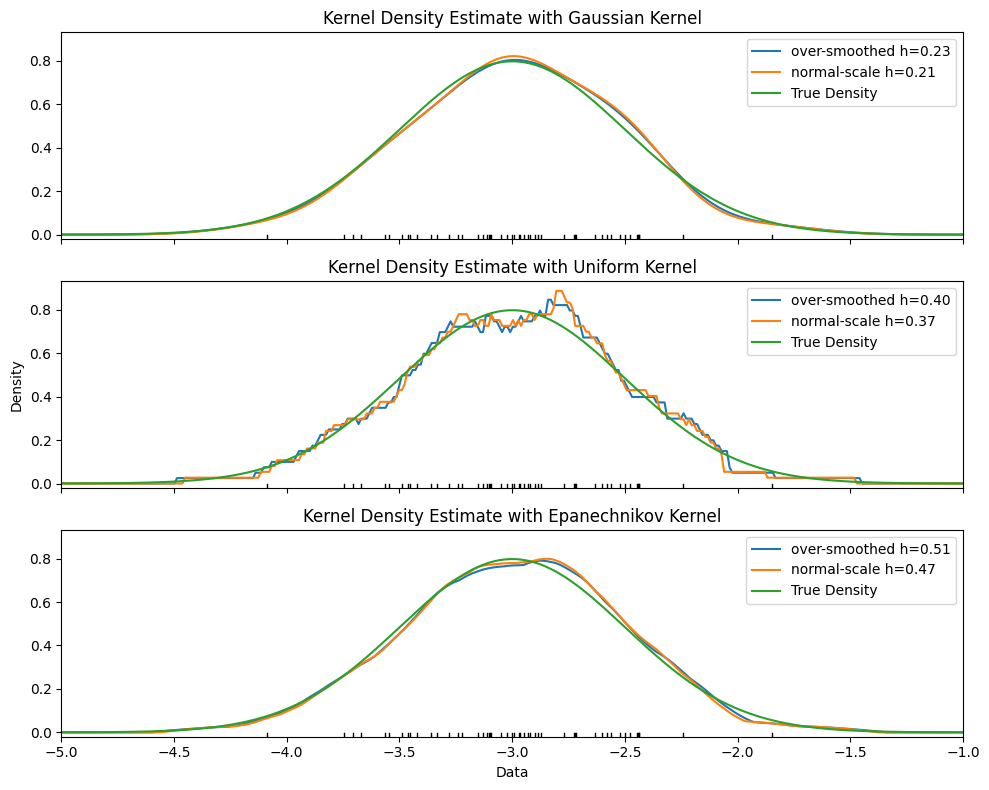

In [137]:
# Illustration with synthetic data from a single normal
data1 = np.random.normal(-3, 0.5, size=50)
x = np.linspace(-6, 6, 1000)

kernel_names = ["Gaussian", "Uniform", "Epanechnikov"]

kernel_func = [gaussian_kernel, uniform_kernel, epanechnikov_kernel]

# oversmoothed and normal scale bandwidths
h_os_gaussian = os_bandwidth(gaussian_kernel, data1)   
h_os_uniform = os_bandwidth(uniform_kernel, data1)  
h_os_epanechnikov = os_bandwidth(epanechnikov_kernel, data1)

h_ns_gaussian = ns_bandwidth(gaussian_kernel, data1)   
h_ns_uniform = ns_bandwidth(uniform_kernel, data1)  
h_ns_epanechnikov = ns_bandwidth(epanechnikov_kernel, data1)

h_os = [h_os_gaussian, h_os_uniform, h_os_epanechnikov]
h_ns = [h_ns_gaussian, h_ns_uniform, h_ns_epanechnikov]

# True density 
x_values = np.linspace(min(data1) - 1, max(data1) + 1, 1000)
true_density1 = stats.norm.pdf(x_values, -3, 0.5)

fig, ax = plt.subplots(3, 1, figsize=(10,8), sharex=True, sharey=True)
ax = ax.flatten()


for i, name in enumerate(kernel_names):

    ax[i].plot(x, custom_kde(data1, kernel_func[i], h_os[i], x), label=f"over-smoothed h={h_os[i]:.2f}")
    ax[i].plot(x, custom_kde(data1, kernel_func[i], h_ns[i], x), label=f"normal-scale h={h_ns[i]:.2f}")
    ax[i].plot(x_values, true_density1, label="True Density")

    for datapoint in data1:
        ax[i].axvline(datapoint, ymin=0, ymax=0.02, color='k', linewidth=1)

    ax[i].legend()
    ax[i].set_title(f'Kernel Density Estimate with {name} Kernel')

ax[1].set_ylabel("Density")


plt.tight_layout()

plt.ylim(bottom=-0.02)
plt.xlim([-5,-1])

plt.xlabel('Data')
#plt.ylabel('Density')
plt.tight_layout()
plt.savefig(os.path.join(plots_folder, 'rot-selector.png'), bbox_inches='tight')
plt.show()